<a href="https://colab.research.google.com/github/wallik3/text-to-emoji/blob/main/notebooks/train_text_to_emoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
- Libraries
- Dataset
- GPU

In [ ]:
%%capture
!pip install transformers

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import sys
import random

from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification

In [ ]:
# Make sure your processer GPU is ready, otherwise, the runtime is too slow
if tf.test.gpu_device_name() == '':
  print("make sure to turn on GPU")
  sys.exit()

else:
  print('GPU enabled')

GPU enabled


In [ ]:
# Obtain dataset for training
!curl https://raw.githubusercontent.com/wallik3/text-to-emoji/main/datasets/train.txt > train.txt
!curl https://raw.githubusercontent.com/wallik3/text-to-emoji/main/datasets/val.txt > val.txt
!curl https://raw.githubusercontent.com/wallik3/text-to-emoji/main/datasets/test.txt > test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1619k  100 1619k    0     0  3058k      0 --:--:-- --:--:-- --:--:-- 3056k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   596k      0 --:--:-- --:--:-- --:--:--  597k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0   743k      0 --:--:-- --:--:-- --:--:--  742k


In [ ]:
col_name = ['text','emoji']

train  = pd.read_csv('/content/train.txt',delimiter=';',header=None,names=col_name)
val =  pd.read_csv('/content/val.txt',delimiter=';',header=None,names=col_name)
test =  pd.read_csv('/content/test.txt',delimiter=';',header=None,names=col_name)

In [ ]:
# Use this if you want to do some quick training
# train = train.sample(1000)
# val = val.sample(150)
# test = test.sample(150)

In [ ]:
# @markdown Every text starts with "I". This indicate that the dataset is not well varied. Consider adding more data with more variety is must

print("Train : ")
display(train.sample(5))

print("Val : ")
display(val.sample(5))

print("Test : ")
display(test.sample(5))

Train : 


,text,emoji
9928,im feeling pressured because it is crunch time...,fear
9472,i feel ashamed of my unproductive days,sadness
15113,i feel the wrapping of the gift is almost as i...,joy
257,i feel not too terribly fond of the majority a...,love
397,i feel distinctly called in clermont to focus ...,love


Val : 


,text,emoji
934,i feel a positive responsibility to see this t...,joy
1014,i feel i should share with you this wonderful ...,joy
1235,i feel this so much more poignantly since the ...,joy
1515,i feel such a longing to be near him when we dont,love
1947,i just cant shake my mood and i feel more list...,sadness


Test : 


,text,emoji
977,i can easily feel quite pressured by routines ...,fear
2,i never make her separate from me because i do...,sadness
640,i am feeling relieved to feel myself again,joy
1629,i listen to it i feel all rebellious,anger
1638,im feeling adventurous i might even make it mu...,joy




---



## Explore data
- Missing value
- Distribution of emoji of every set of data

In [ ]:
# @markdown - None of these set has missing value

def has_missing_value(df):
   return df.isna().sum().all() != 0

print("Has Missing value")
print(f'train : {has_missing_value(train)}')
print(f'val : {has_missing_value(val)}')
print(f'test : {has_missing_value(test)}')

Has Missing value
train : False
val : False
test : False


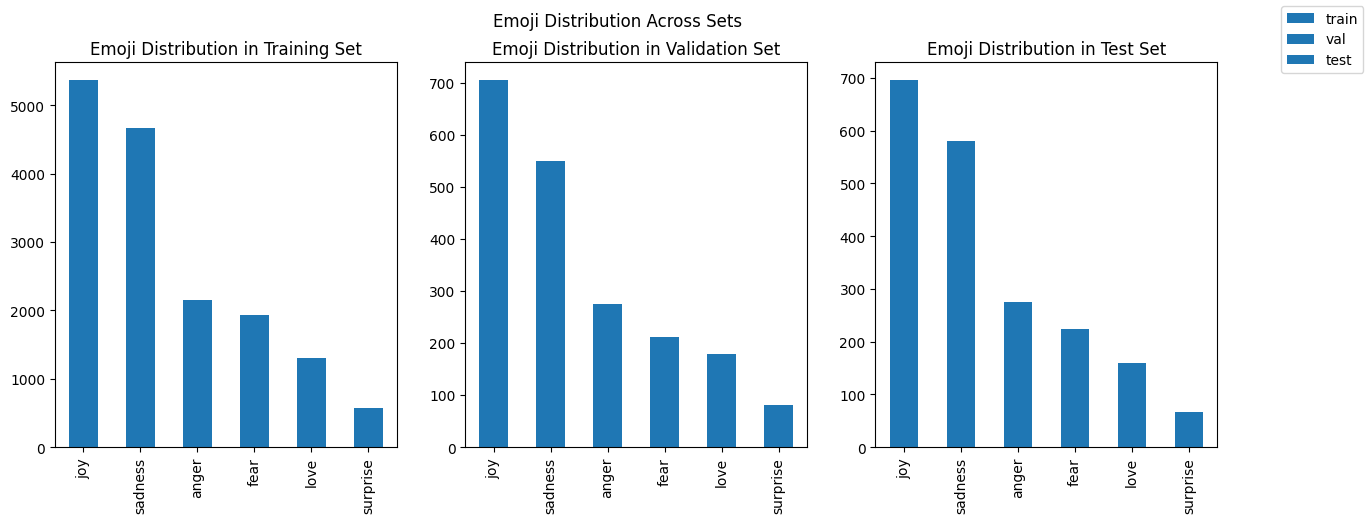

In [ ]:
# @markdown - The emoji frequency appears similar across the training, validation, and test sets. This is acceptable to do unbias evaluation for the model.

# @markdown - The actual concern lies in the potential imbalance of the dataset, as previously highlighted

# @markdown - To ensure unbiased evaluation, we need to carefully consider techniques to mitigate the impact of imbalanced data.

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the bar charts for each dataset
pd.value_counts(train['emoji']).plot.bar(ax=ax1, label='train')
pd.value_counts(val['emoji']).plot.bar(ax=ax2, label='val')
pd.value_counts(test['emoji']).plot.bar(ax=ax3, label='test')

# Add labels, title, and legend
ax1.set_title('Emoji Distribution in Training Set')
ax2.set_title('Emoji Distribution in Validation Set')
ax3.set_title('Emoji Distribution in Test Set')
fig.suptitle('Emoji Distribution Across Sets')  # Overall title for the figure
fig.legend()
plt.show()



---



## Preprocess the dataset
- Make sure the format of data is appropriate to the model

In [ ]:
df_train = train.copy()
df_val = val.copy()
df_test = test.copy()

In [ ]:
# Make label numerical
from typing import Dict

def get_unique_label_value(df:pd.DataFrame,label="emoji")-> Dict[str, int]:
  """
  Obtaining the unique value of label, and encode them into integer

  Sorted by alphabet (A-Z)
  """
  possible_labels = df[label].unique()
  possible_labels.sort()

  label_dict = {}
  for index, possible_label in enumerate(possible_labels):
      label_dict[possible_label] = index

  return label_dict

label_dict = get_unique_label_value(df_train)
print(f"{label_dict = }")

label_dict = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
# Replace label string to encoded label
df_train['label'] = df_train['emoji'].replace(label_dict)
df_val['label'] = df_val['emoji'].replace(label_dict)
df_test['label'] = df_test['emoji'].replace(label_dict)

In [ ]:
display(df_train.sample(5))
display(df_val.sample(5))

,text,emoji,label
10457,i don t feel like this month was a failure but...,joy,2
5946,i completed feeling invigorated not sluggish i...,joy,2
7154,i grow learn more and mature a little more whi...,joy,2
12124,i could do was feel i felt thankful that her b...,joy,2
11507,i listen to the cd i am left feeling a little ...,joy,2


,text,emoji,label
530,i feel pretty safe but i do realize that we do...,joy,2
436,i feel so rebellious on my parents for not let...,anger,0
66,i look and feel miserable,sadness,4
255,ive been sitting in my wheel chair to move lau...,joy,2
1868,i feel funny things happening to my face and a...,surprise,5


In [ ]:
# Split the data (both train and val)

(X_train , y_train) = (df_train.text , df_train.emoji)
(X_val , y_val) = (df_val.text , df_val.emoji)

In [ ]:
#Check the count of both train and val

label_count = pd.concat([train,val],axis=0)
label_count.reset_index(drop=True,inplace=True)
label_count['label'] = label_count.emoji.replace(label_dict)
label_count['data_type'] = ['not_set']*label_count.shape[0]

label_count.loc[:16000, 'data_type'] = 'train'
label_count.loc[16000:, 'data_type'] = 'val'

label_count.groupby(['emoji', 'label', 'data_type']).count()

#We don't use anymore
del label_count

## Prepare our (pre-trained) tokenizer and model
- Setup the model and tokenizer

In [ ]:
# construct BERT tokenizer ( known as WordPiece )

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      # No attention and hidden state as an output
                                                      output_attentions=False,
                                                      output_hidden_states=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess the dataset (again) by splitting text to a list of token
- Split the text into a list of token  


In [ ]:
# Prepare device (expect GPU called CUDA)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f'Current device : {device}')

Current device : cuda


In [ ]:
{'emoji', 'text'}.issubset(set(df_train.columns))

True

In [ ]:
df_train.columns

Index(['text', 'emoji', 'label'], dtype='object')

In [ ]:
# @markdown # Tokenize the text
# @markdown - Since we are going to train with batch data, every data does not have the same length

# @markdown - Batch dataset must represent in form of rectangular matrix. In other word, every data have the same length

# @markdown - One of the common techniques is to use attention mask

# Common shared keyword arguments for tokenizer for train and val
def df_to_tensor_dataset(df:pd.DataFrame,
                         x:str="text",
                         y:str="label",
                         is_onehot=False)->TensorDataset:

  # Setup the default config
  tokenizer_configs =  dict(
      add_special_tokens=True, #special token used to make arrays of tokens the same size for batching purpose (which fulfill by zero element when the size is small)
      return_attention_mask=True, # we want attention mask too, to don't fully show text all text, but we hide some
      padding='longest', #Padding the returned sequence to fit the max length (maybe if the returned sequence is larger than max length)
      max_length=256, #limit the size of numerical token
      return_tensors='pt' #return the numerical tokens in form of PyTorch
    )

  # Tokenize text into input_ids and attention mask
  encoded_data = tokenizer.batch_encode_plus(
      batch_text_or_text_pairs = df[x].values,
      **tokenizer_configs)

  # Get three essential representation of data (X, y)
  input_ids = encoded_data['input_ids'].to(device)
  attention_masks = encoded_data['attention_mask'].to(device)

  # Make one hot encoder
  if is_onehot:
    df[y] = pd.Categorical(df[y], categories=[0, 1, 2, 3, 4, 5])
    dummies = pd.get_dummies(df[y], prefix='label')
    labels = torch.tensor(dummies.values).to(device)
  else:
    labels = torch.tensor(df[y].values).to(device)

  #We want tensor dataset, cuz one feature can store matrix ( 1d+ tensor) instead of just scalar ( 1d tensor) )
  dataset = TensorDataset(input_ids, attention_masks, labels)
  return dataset

In [ ]:
train_set = df_to_tensor_dataset(df_train)
val_set = df_to_tensor_dataset(df_val)
test_set = df_to_tensor_dataset(df_test)

In [ ]:
# @markdown If we take a look at how the data looks like. It will contain Input Id, Attention mask, and label
# @markdown Attention Mask tells the model to focus or ignore while training (0 : Ignore)
# @markdown Attention mask is needed to make us able to do Batch Gradient descent (Since each observation in dataset should have the same dimension)
data_index = 3
print(f"Actual text : {train.iloc[data_index].text}")
print(f"Input Id : {train_set[data_index][0]}")
print(f"Attention Mask : {train_set[data_index][1]}")
print(f"Label : {train_set[data_index][2]}")

Actual text : i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Input Id : tensor([  101,  1045,  2572,  2412,  3110, 16839,  9080, 12863,  2055,  1996,
        13788,  1045,  2097,  2113,  2008,  2009,  2003,  2145,  2006,  1996,
         3200,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
Attention Mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [ ]:
# @markdown # Make DataLoader
# @markdown - In machine learning, handling large datasets can be challenging due to memory limitations. Dataloaders help us overcome this by splitting the data into manageable pieces called batches. This technique, known as minibatching, allows us to train models efficiently without overwhelming our system's memory. Also make the convergence of the optimal parameter faster
# @markdown - Dataloaders simplify the process of mini-batching
# @markdown - You can specify the size of each batch by adjusting the below slider

batch_size = 4 #@param {type:"slider", min:1, max:32, step:1}

# randomly shuffle the data;
train_loader = DataLoader(train_set,
                          sampler=RandomSampler(train_set),
                          batch_size=batch_size)

# order the data
val_loader = DataLoader(val_set,
                        sampler=SequentialSampler(val_set),
                        batch_size=batch_size)

# order the data
test_loader = DataLoader(test_set,
                        sampler=SequentialSampler(test_set),
                        batch_size=batch_size)

print(f"{len(train_loader) = }")
print(f"{len(val_loader) = }")

len(train_loader) = 4000
len(val_loader) = 500


In [ ]:
def get_weights_from_label(df):
  train_value_counts = df.label.value_counts()
  train_value_counts.sort_index(inplace=True)

  weights = []
  for value_count in train_value_counts:

    weight = len(df) / value_count
    weights.append(weight)

  weights = torch.tensor(weights)
  return weights

In [ ]:
weights = get_weights_from_label(df_train)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# @markdown # Setup trainer
# @markdown - Our goal is to adapt the pre-trained model to our emoji dataset
# @markdown - Since the way to update the parameter in

# Config the optimizer hyperparameter
epochs = 5 #@param {type:"slider", min:1, max:100, step:1}
lr = 1e-5
eps = 1e-8
# https://discuss.huggingface.co/t/class-weights-for-bertforsequenceclassification/1674/7
criterion = torch.nn.CrossEntropyLoss(weight=weights,reduction='mean').to(device)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=eps)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# @markdown # Setup Evaluation Metric
# @markdown - Define how we evaluate the performance of the model
# @markdown - We employ the common metric for multi-class classification, weighted F1 score

from sklearn.metrics import f1_score
from typing import Dict

def get_f1_score(preds, labels)->float:
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def get_accuracy_per_class(preds, labels)->Dict[str,float]:
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    accuracy_per_class = {}

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        emoji_class = label_dict_inverse[label]
        correct = len(y_preds[y_preds==label])
        total = len(y_true)
        accuracy = f"{correct}/{total}"

        accuracy_per_class[emoji_class] = accuracy

    return accuracy_per_class

eval_metric = get_f1_score

In [ ]:
def prediction_for_one_word(preds):
  preds_flat = np.argmax(preds, axis=0).flatten()

  return preds_flat

#Training Loops

In [ ]:
#Set Random seed (for predictable random result)

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# Prepare device (expect GPU called CUDA)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f'Current device : {device}')

Current device : cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import Callable

def hardmax(arr):
  """
  Performs the hardmax operation on an array, element-wise.

  Args:
      arr: A NumPy array of any shape.

  Returns:
      A NumPy array of the same shape as the input array, containing the index
      of the maximum element along each axis.
  """

  # Ensure the array is of type float for numerical stability
  arr = arr.astype(np.float32)

  # Find the indices of the maximum elements along each axis
  return np.argmax(arr, axis=1)

def get_preds_and_truths(model, loader, device):
    """Collects model predictions and ground-truth labels for a given loader."""
    preds, truths = [], []

    for batch in loader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs[1]
            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            preds.append(logits)
            truths.append(label_ids)

    preds = np.concatenate(preds, axis=0)
    truths = np.concatenate(truths, axis=0)
    return preds, truths

def train_epoch(model, train_loader, device, optimizer, scheduler, eval_metric:Callable):
    """Trains the model for one epoch."""
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_loader, desc='Epoch', leave=False, disable=False)
    for batch in progress_bar:
        # batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        logits = outputs["logits"]
        loss = criterion(logits, inputs["labels"])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        loss_train_total += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    train_loss_avg = loss_train_total / len(train_loader)

    preds, truths = get_preds_and_truths(model, train_loader, device)
    train_f1_score = eval_metric(preds, truths)

    return train_loss_avg, train_f1_score

def evaluate(model, loader, device, eval_metric:Callable):
    """Evaluates the model on the validation set."""
    model.eval()

    preds, truths = get_preds_and_truths(model, loader, device)
    f1_score = eval_metric(preds, truths)
    cache = (preds, truths)
    return f1_score, cache

def train_model(model, train_loader, val_loader, device, criterion, optimizer, scheduler, epochs, eval_metric):
    """Runs the main training loop."""
    best_f1_score = 0

    for epoch in tqdm(range(1, epochs+1)):
        # Updating the parameter of the model
        train_loss, train_f1 = train_epoch(model, train_loader, device, optimizer, scheduler, eval_metric)
        tqdm.write(f'\nEpoch {epoch} : ')
        tqdm.write(f'Training loss: {train_loss}')
        tqdm.write(f'Training Weighted F1: {train_f1}')

        # Report the accuracy of the model
        val_f1, _ = evaluate(model, val_loader, device, eval_metric)
        tqdm.write(f'Val Weighted F1 Score : {val_f1}')

        # Hop the model (We save the weight at the last and best epoch based on F1 score)
        torch.save(model.state_dict(), f'/content/last.model')

        if val_f1 > best_f1_score:
          print(f"Best model saved at epoch {epoch}")
          torch.save(model.state_dict(), f'/content/best.model')

In [ ]:
train_model(model, train_loader, val_loader, device, criterion , optimizer, scheduler, epochs, eval_metric)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]


Epoch 1 : 
Training loss: 0.5329548989401519
Training Weighted F1: 0.9422270438695632
Val Weighted F1 Score : 0.9294212652464445
Best model saved at epoch 1


Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]


Epoch 2 : 
Training loss: 0.2555533643786475
Training Weighted F1: 0.9581568462056199
Val Weighted F1 Score : 0.9306520117301886
Best model saved at epoch 2


Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]


Epoch 3 : 
Training loss: 0.1930508168453598
Training Weighted F1: 0.9666645984156018
Val Weighted F1 Score : 0.9311113607363231
Best model saved at epoch 3


Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]


Epoch 4 : 
Training loss: 0.13721496927496993
Training Weighted F1: 0.9803200638811197
Val Weighted F1 Score : 0.9346772191529871
Best model saved at epoch 4


Epoch:   0%|          | 0/4000 [00:00<?, ?it/s]


Epoch 5 : 
Training loss: 0.0905171191897316
Training Weighted F1: 0.9861601785792998
Val Weighted F1 Score : 0.9379681936009753
Best model saved at epoch 5


In [ ]:
# Copy the best model into your drive (Temporary)
!cp /content/best.model /content/drive/MyDrive

In [ ]:
# @markdown # Load the best version of the model
# @markdown - Recall that we saved the best parameter at 'best.model'
# @markdown Load the parameter at best epoch to the model

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
model.load_state_dict(torch.load(f'/content/best.model', map_location=torch.device('cpu')))

val_f1_score, (preds, truth) = evaluate(model, val_loader, device, eval_metric)
print("Validation Set Prediction : ")
print(f"{val_f1_score = }")
print(get_accuracy_per_class(preds, truth))
print("\n")

print("Test Set Prediction : ")
test_f1_score, (preds, truth) = evaluate(model, test_loader, device, eval_metric)
print(f"{test_f1_score = }")
print(get_accuracy_per_class(preds, truth))
preds = hardmax(preds)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Set Prediction : 
val_f1_score = 0.9379681936009753
{'anger': '261/275', 'fear': '189/212', 'joy': '671/704', 'love': '154/178', 'sadness': '531/550', 'surprise': '70/81'}


Test Set Prediction : 
test_f1_score = 0.9265368825740791
{'anger': '256/275', 'fear': '200/224', 'joy': '649/695', 'love': '136/159', 'sadness': '560/581', 'surprise': '51/66'}


In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(truths, preds, label_dict:Dict):

  class_labels = list(label_dict.keys())

  # Get confusion matrix
  cm = confusion_matrix(truth, preds, normalize="pred")

  # Plot the confusion matrix
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.matshow(cm, cmap='Blues', alpha=0.7)

  # Set ticks for each cell
  for (i, j), z in np.ndenumerate(cm):
      ax.text(j, i, str(round(z,5)), ha='center', va='center', fontsize=8)

  # Set labels and title
  ax.set_xticks(np.arange(len(class_labels)))
  ax.set_yticks(np.arange(len(class_labels)))
  ax.set_xticklabels(class_labels, rotation=45, ha='right')
  ax.set_yticklabels(class_labels)
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('True Label')
  ax.set_title('Confusion Matrix')

  # Show the plot
  plt.tight_layout()
  plt.show()

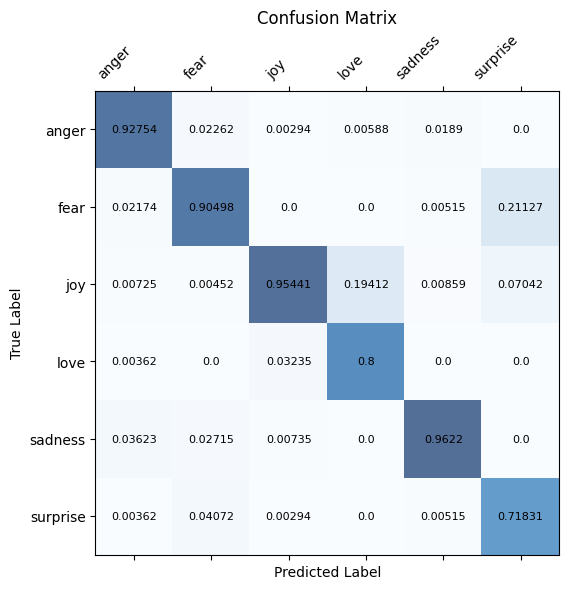

In [ ]:
get_confusion_matrix(truth, preds, label_dict)

In [ ]:
# @markdown # Set End user function
# @markdown - Let's now build a function which take text and inference into softmax
from torch.nn.functional import softmax

def pipeline(text,
             tokenizer=tokenizer,
             model=model,
             device=device):

  tokenizer_configs =  dict(
      add_special_tokens=True,
      return_attention_mask=True,
      padding='longest',
      max_length=256,
      return_tensors='pt'
    )
  # Encode text into input_ids and attention_masks
  encoded_word = tokenizer.batch_encode_plus([text],**tokenizer_configs)
  input_ids = encoded_word['input_ids'].to(device)
  attention_masks = encoded_word['attention_mask'].to(device)
  model = model.to(device)
  # Inference
  outputs = model(input_ids=input_ids,
                  attention_mask=attention_masks)

  prob = softmax(outputs.logits,dim=1)
  prob = prob.detach().cpu().numpy()
  pred = hardmax(prob)
  return prob, pred

# Setup dictionary for interpreting the result
label_dict_inverse = {v: k for k, v in label_dict.items()}
emoji_dict = {
         'anger' : '😡',
         'fear':'😨',
         'joy':'😂',
         'love': '❤️',
         'sadness' : '😔',
         'surprise':'😮',
         }

In [ ]:
test_word = "Have you ever think about the murderer, It's so creepy" #@param {type:"string"}
prob, pred = pipeline(test_word)
pred = pred[0]

# Plot
emoji_name = label_dict_inverse[pred]
emoji = emoji_dict[emoji_name]
print(f"{test_word} {emoji}")

Have you ever think about the murderer, It's so creepy 😨


# What's Next ⏭
- Get the data with more variety (See that most of them start with "I")
- Carry out error analysis. Some words can be interpreted as mroe than 1 emoji